In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
plt.rcParams['figure.facecolor'] = 'w'

In [4]:
from google.colab import drive
drive.mount('/content/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Drive


In [0]:
data = pd.read_csv('/content/Drive/My Drive/Colab Notebooks/Project2/1000mlRetail.csv')

In [6]:
data.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2016-124891,2016-07-31,2016-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2017-77878,2017-02-05,2017-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical


In [7]:
data.dtypes

Row ID              int64
Order ID           object
Order Date         object
Ship Date          object
Ship Mode          object
Customer ID        object
Customer Name      object
Segment            object
City               object
State              object
Country            object
Postal Code       float64
Market             object
Region             object
Product ID         object
Category           object
Sub-Category       object
Product Name       object
Sales             float64
Quantity            int64
Discount          float64
Profit            float64
Shipping Cost     float64
Order Priority     object
dtype: object

In [8]:
data.isnull().sum()

Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

In [9]:
print(f'Column: Unique Values')
print('---------------------')

for name in data.columns:
  print(f'{name}: {len(data[name].unique())}')

Column: Unique Values
---------------------
Row ID: 51290
Order ID: 25035
Order Date: 1430
Ship Date: 1460
Ship Mode: 4
Customer ID: 1590
Customer Name: 795
Segment: 3
City: 3636
State: 1094
Country: 147
Postal Code: 632
Market: 7
Region: 13
Product ID: 10292
Category: 3
Sub-Category: 17
Product Name: 3788
Sales: 22995
Quantity: 14
Discount: 27
Profit: 24575
Shipping Cost: 10037
Order Priority: 4


In [10]:
for name in data.columns:
  if len(data[name].unique()) < 24:
    print(f'{name}: {data[name].unique()}')

Ship Mode: ['Same Day' 'Second Class' 'First Class' 'Standard Class']
Segment: ['Consumer' 'Corporate' 'Home Office']
Market: ['US' 'APAC' 'EU' 'Africa' 'EMEA' 'LATAM' 'Canada']
Region: ['East' 'Oceania' 'Central' 'Africa' 'West' 'South' 'Central Asia' 'EMEA'
 'North Asia' 'North' 'Caribbean' 'Southeast Asia' 'Canada']
Category: ['Technology' 'Furniture' 'Office Supplies']
Sub-Category: ['Accessories' 'Chairs' 'Phones' 'Copiers' 'Tables' 'Binders' 'Supplies'
 'Appliances' 'Machines' 'Bookcases' 'Storage' 'Furnishings' 'Art' 'Paper'
 'Envelopes' 'Fasteners' 'Labels']
Quantity: [ 7  9  5  8  4  6 13 12 14 10  2 11  3  1]
Order Priority: ['Critical' 'Medium' 'High' 'Low']


In [0]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])

In [0]:
def col_to_category(columns):
  for name in columns:
    data[name] = data[name].astype('category')

In [0]:
col_to_categorize = []
for name in data.drop('Quantity',1).columns:
  if len(data[name].unique()) < 25:
    col_to_categorize.append(name)

col_for_model = col_to_categorize #+ ['Sales','Quantity','Discount','Profit','Shipping Cost']    

In [102]:
data[col_for_model].head(2)

,Ship Mode,Segment,Market,Region,Category,Sub-Category,Order Priority
513,First Class,Corporate,APAC,Central Asia,Technology,Machines,High
514,Same Day,Corporate,APAC,Central Asia,Technology,Phones,Critical


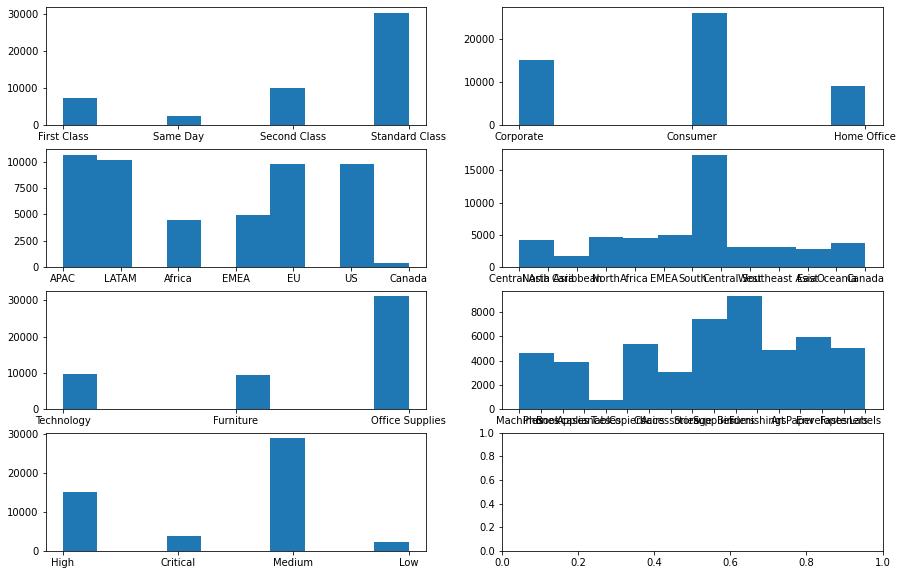

In [107]:
fig, axs = plt.subplots(4,2, figsize=(15,10))

for column, ax in zip(data[col_for_model].columns, axs.flatten()[:7]):
  ax.hist(data[column])

plt.show()

In [15]:
data.corr()['Sales']
#drop Row ID, Postal Code and Discount as a variable because the correlation is below 0.2 as a threshold

Row ID          -0.043889
Postal Code     -0.023854
Sales            1.000000
Quantity         0.313577
Discount        -0.086722
Profit           0.484918
Shipping Cost    0.768073
Name: Sales, dtype: float64

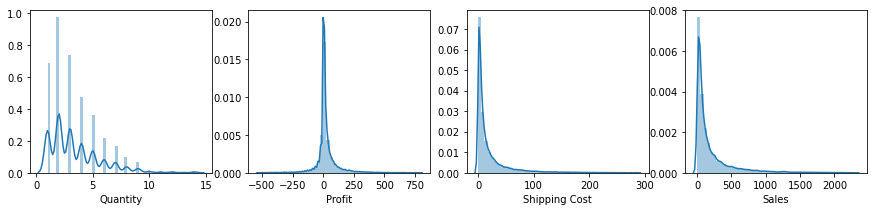

In [98]:
fig, axs = plt.subplots(1,4, figsize=(15,3))

for column, ax in zip(['Quantity','Profit','Shipping Cost','Sales'], axs.flatten()[:4]):
  sns.distplot(data[column],ax=ax)

plt.show()

In [0]:
q_SC = data['Shipping Cost'].quantile(0.99)
q_S = data['Sales'].quantile(0.99)
q_P1 = data['Profit'].quantile(0.005)
q_P2 = data['Profit'].quantile(0.995)

In [18]:
data = data[data['Shipping Cost']<q_SC][data['Sales']<q_S][data['Profit']>q_P1][data['Profit']<q_P2]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


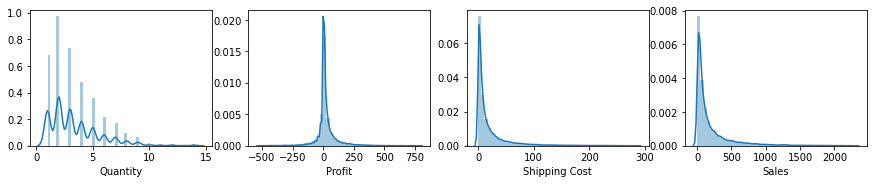

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,2.5))

sns.distplot(data['Quantity'],ax=ax1)

sns.distplot(data['Profit'],ax=ax2)

sns.distplot(data['Shipping Cost'],ax=ax3)

sns.distplot(data['Sales'],ax=ax4)

plt.show()

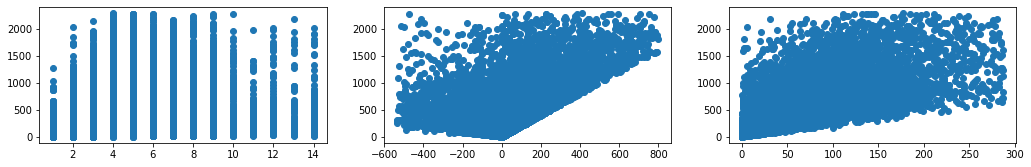

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17.5,2.5))

ax1.scatter(data['Quantity'], data['Sales'])

ax2.scatter(data['Profit'], data['Sales'])

ax3.scatter(data['Shipping Cost'], data['Sales'])

plt.show()

In [0]:
def log_base(x, base):
  return np.log(x)/np.log(base)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


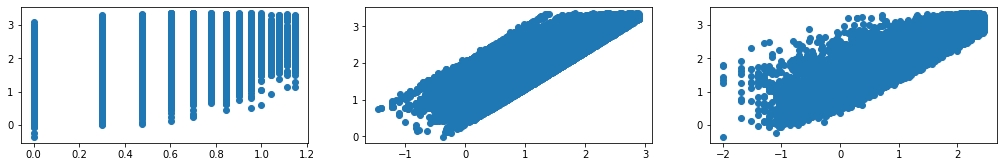

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17.5,2.5))

ax1.scatter( log_base(data['Quantity'],10) , log_base(data['Sales'],10) )

ax2.scatter( log_base(data['Profit'],10) , log_base(data['Sales'],10) )

ax3.scatter( log_base(data['Shipping Cost'],10) , log_base(data['Sales'],10) )

plt.show()

#No Transformation

In [0]:
#set variables
x = data[['Quantity','Profit','Shipping Cost']]
y = data['Sales']

#add constant
x = sm.add_constant(x)

In [24]:
#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                 3.335e+04
Date:                Thu, 30 Apr 2020   Prob (F-statistic):               0.00
Time:                        03:46:07   Log-Likelihood:            -2.6231e+05
No. Observations:               40200   AIC:                         5.246e+05
Df Residuals:                   40196   BIC:                         5.247e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.0304      1.519      8.579      0.000      10.053      16.007
Quantity         12.7817      0.382     33.440      0.000      12.033      13.531
Profit            0.6332      0.009     67.656      0.000       0.615       0.652
Shipping Cost     6.2321      0.026    236.606      0.000       6.180       6.284
==============================================================================
Omnibus:                    21103.356   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           484482.168
Skew:                           2.038   Prob(JB):                         0.00
Kurtosis:                      19.511   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
#Predicted values of the trained data set
y_prediction_test = lin_model.predict(x_test)

#test value, based on the trained data set
r2_score(y_test, y_prediction_test)

0.6992838223863413

#With Transformation

In [0]:
import warnings
warnings.filterwarnings('ignore')

#set variables
x = data[['Quantity','Profit','Shipping Cost']]
y = log_base(data['Sales'] ,10)

x['Quantity'] = log_base( data['Quantity'] + abs(min(data['Quantity'])) +1 ,10)
x['Profit'] = log_base( data['Profit'] + abs(min(data['Profit'])) +1 ,10)
x['Shipping Cost'] = log_base( data['Shipping Cost'] + abs(min(data['Shipping Cost'])) +1 ,10)

#add constant
x = sm.add_constant(x)

In [27]:
#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                 6.210e+04
Date:                Thu, 30 Apr 2020   Prob (F-statistic):               0.00
Time:                        03:46:07   Log-Likelihood:                -2299.3
No. Observations:               40200   AIC:                             4607.
Df Residuals:                   40196   BIC:                             4641.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2727      0.039      6.916      0.000       0.195       0.350
Quantity          0.3433      0.008     40.816      0.000       0.327       0.360
Profit            0.1635      0.014     11.361      0.000       0.135       0.192
Shipping Cost     0.9711      0.003    379.459      0.000       0.966       0.976
==============================================================================
Omnibus:                     2285.815   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5366.435
Skew:                           0.358   Prob(JB):                         0.00
Kurtosis:                       4.641   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
#Predicted values of the trained data set
y_prediction_test = lin_model.predict(x_test)

#test value, based on the trained data set
r2_score(y_test, y_prediction_test)

0.8202900334476936

# With Scaling and Transformation, and Dummies

In [0]:
import warnings
warnings.filterwarnings('ignore')

#set variables
x = data[['Quantity','Profit','Shipping Cost']]
y = log_base(data['Sales'] ,10)

x['Profit'] = log_base( data['Profit'] + abs(min(data['Profit'])) +1 ,10)
x['Shipping Cost'] = log_base( data['Shipping Cost'] + abs(min(data['Shipping Cost'])) +1 ,10)

In [114]:
dummy_variables = data[col_for_model].drop(['Segment','Region','Category'],axis=1)
dummy_variables.head(2)

,Ship Mode,Market,Sub-Category,Order Priority
513,First Class,APAC,Machines,High
514,Same Day,APAC,Phones,Critical


In [116]:
dummy = pd.get_dummies(dummy_variables, drop_first=True)
dummy.head(2)

,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Market_Africa,Market_Canada,Market_EMEA,Market_EU,Market_LATAM,Market_US,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Order Priority_High,Order Priority_Low,Order Priority_Medium
513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
514,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [117]:
x = pd.concat([x,dummy],axis=1)
x.head(2)

,Quantity,Profit,Shipping Cost,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Market_Africa,Market_Canada,Market_EMEA,Market_EU,Market_LATAM,Market_US,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Order Priority_High,Order Priority_Low,Order Priority_Medium
513,6,3.007301,2.459000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
514,5,2.900440,2.458895,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [118]:
#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )


# create a standard scaler for each variable and variable partition
for col in x_train.columns:
  ss_x_train = StandardScaler()
  x_train[col] = ss_x_train.fit_transform(np.array(x_train[col]).reshape(-1,1))

  ss_x_test = StandardScaler()
  x_test[col] = ss_x_test.fit_transform(np.array(x_test[col]).reshape(-1,1))

# fit the fit_transform train set
ss_y_train = StandardScaler()
y_train = ss_y_train.fit_transform(np.array(y_train).reshape(-1,1))

#fit the fit_transform test set
ss_y_test = StandardScaler()
y_test = ss_y_test.fit_transform(np.array(y_test).reshape(-1,1))

#add constant to train and test x
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 1.153e+04
Date:                Thu, 30 Apr 2020   Prob (F-statistic):               0.00
Time:                        04:29:14   Log-Likelihood:                -10968.
No. Observations:               40200   AIC:                         2.200e+04
Df Residuals:                   40168   BIC:                         2.228e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1.615e-16      0.002  -1.02e-13      1.000      -0.003       0.003
Quantity                     0.1135      0.002     60.105      0.000       0.110       0.117
Profit                       0.0262      0.002     15.881      0.000       0.023       0.029
Shipping Cost                0.7833      0.003    299.695      0.000       0.778       0.788
Ship Mode_Same Day           0.0048      0.002      2.678      0.007       0.001       0.008
Ship Mode_Second Class       0.0442      0.002     19.907      0.000       0.040       0.049
Ship Mode_Standard Class     0.0958      0.003     38.170      0.000       0.091       0.101
Market_Africa               -0.0209      0.002    -11.341      0.000      -0.025      -0.017
Market_Canada                0.0034      0.002      2.138      0.033       0.000       0.007
Market_EMEA                 -0.0244      0.002    -13.061      0.000      -0.028      -0.021
Market_EU                    0.0090      0.002      4.534      0.000       0.005       0.013
Market_LATAM                -0.0288      0.002    -14.431      0.000      -0.033      -0.025
Market_US                   -0.0710      0.002    -34.611      0.000      -0.075      -0.067
Sub-Category_Appliances      0.0145      0.002      7.493      0.000       0.011       0.018
Sub-Category_Art            -0.0631      0.003    -25.193      0.000      -0.068      -0.058
Sub-Category_Binders        -0.1147      0.003    -42.419      0.000      -0.120      -0.109
Sub-Category_Bookcases       0.0316      0.002     15.108      0.000       0.028       0.036
Sub-Category_Chairs          0.0227      0.002     10.160      0.000       0.018       0.027
Sub-Category_Copiers         0.0332      0.002     16.052      0.000       0.029       0.037
Sub-Category_Envelopes      -0.0452      0.002    -21.279      0.000      -0.049      -0.041
Sub-Category_Fasteners      -0.0783      0.002    -35.984      0.000      -0.083      -0.074
Sub-Category_Furnishings    -0.0259      0.002    -11.686      0.000      -0.030      -0.022
Sub-Category_Labels         -0.0991      0.002    -44.320      0.000      -0.103      -0.095
Sub-Category_Machines        0.0148      0.002      7.739      0.000       0.011       0.018
Sub-Category_Paper          -0.0472      0.002    -20.553      0.000      -0.052      -0.043
Sub-Category_Phones          0.0249      0.002     11.224      0.000       0.021       0.029
Sub-Category_Storage        -0.0105      0.002     -4.251      0.000      -0.015      -0.006
Sub-Category_Supplies       -0.0332      0.002    -15.769      0.000      -0.037      -0.029
Sub-Category_Tables          0.0312      0.002     17.235      0.000       0.028       0.035
Order Priority_High          0.1254      0.003     40.109      0.000       0.119       0.132
Order Priority

In [120]:
#Predicted values of the trained data set
y_prediction_test = lin_model.predict(x_test)

#test value, based on the trained data set
r2_score(y_test, y_prediction_test)

0.8996501539232941

#Other Stuff

In [32]:
for col in ['Quantity','Discount','Profit','Shipping Cost']:
  print(col)

Quantity
Discount
Profit
Shipping Cost


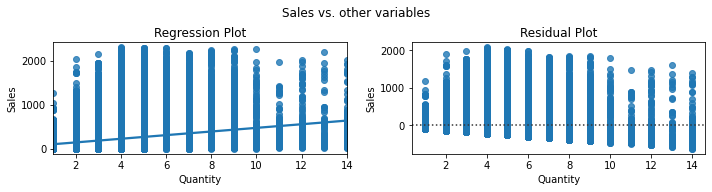

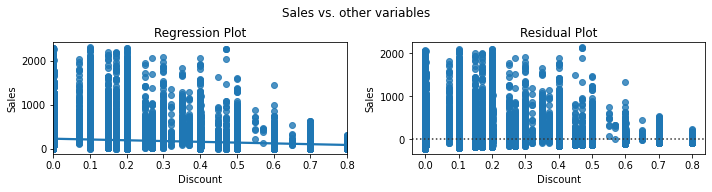

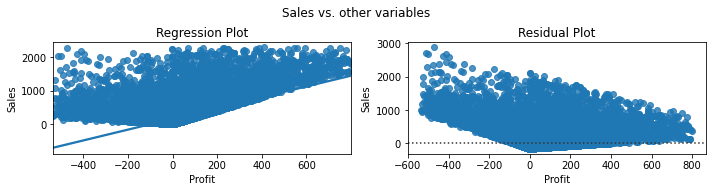

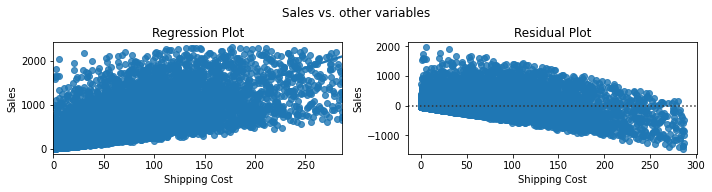

In [33]:
for col in ['Quantity','Discount','Profit','Shipping Cost']:
  #subsetting dataframe for each unique value

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,2.5))
  #fig - overall figure
  #ax1 - axis object for left plot
  #ax2 - axis object for right plot
  sns.regplot(x=col, y='Sales',
              data = data,
              ci = 95,
              ax=ax1)
  sns.residplot(x=col,y='Sales',
                data = data,
                ax=ax2)
  #Setting title of left plot
  ax1.set_title('Regression Plot')
  #setting title of right plot
  ax2.set_title('Residual Plot')
  # making layout nice and pretty
  plt.tight_layout()
  # overall title on figure
  fig.suptitle(f'Sales vs. other variables', y = 1.05)
  plt.show()

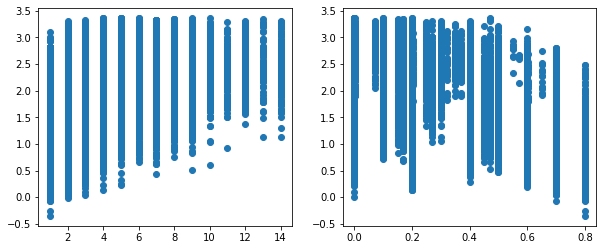

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(data['Quantity'], np.log(data['Sales']) / np.log(10) )

ax2.scatter(data['Discount'], np.log(data['Sales']) / np.log(10) )

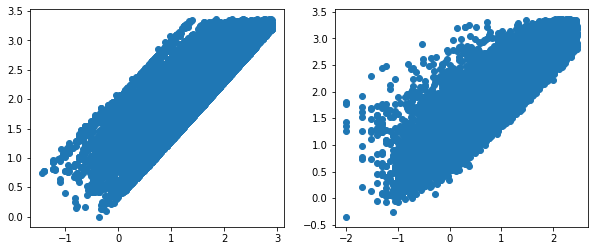

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(np.log(data['Profit']) / np.log(10), np.log(data['Sales']) / np.log(10) )

ax2.scatter(np.log(data['Shipping Cost']) / np.log(10), np.log(data['Sales']) / np.log(10) )

In [36]:
abc = [1,2,3]

np.power(10,abc)

array([  10,  100, 1000])

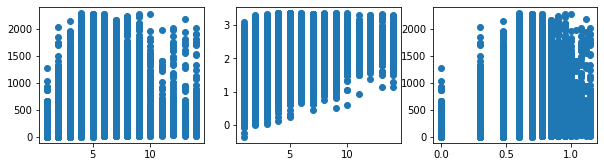

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,2.5))

ax1.scatter(data['Quantity'], data['Sales'])

ax2.scatter(data['Quantity'], np.log(data['Sales']) / np.log(10) )

ax3.scatter(np.log(data['Quantity']) / np.log(10), data['Sales'])

plt.show()

In [38]:
np.power(10,data['Quantity'])

513       1000000
514        100000
515          1000
517      10000000
519          1000
           ...   
51285      100000
51286          10
51287        1000
51288         100
51289        1000
Name: Quantity, Length: 50250, dtype: int64

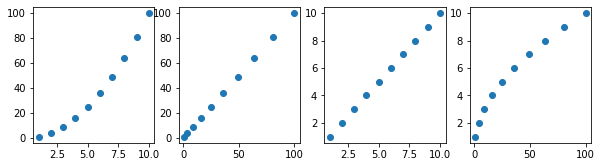

In [39]:
xx = [1,2,3,4,5,6,7,8,9,10]
yy = np.power(xx,2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(10,2.5))

ax1.scatter(xx,yy)

ax2.scatter(np.power(xx,2),yy)

ax3.scatter(xx,np.sqrt(yy))

ax4.scatter(np.power(xx,2),np.sqrt(yy))

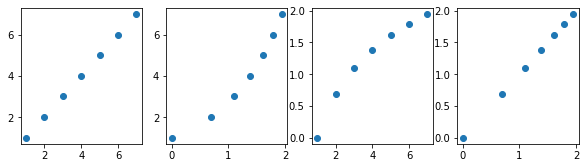

In [40]:
xx = [1,2,3,4,5,6,7]
yy = [1,2,3,4,5,6,7]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(10,2.5))

ax1.scatter(xx,yy)

ax2.scatter(np.log(xx),yy)

ax3.scatter(xx,np.log(yy))

ax4.scatter(np.log(xx),np.log(yy))